In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import h5py
from peakfinder import detect_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import scipy as sp
from sklearn.metrics import classification_report
import similaritymeasures
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [2]:
#df_labels = pd.read_csv(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Scripts\smooth_labels.dat',delimiter = '\s+',header = None,index_col = None)
#df_labels = pd.read_csv(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Scripts\modified_labels1.txt',delimiter = '\s+',header = None,index_col = None)
df_labels = pd.read_csv(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Scripts\new labels1.txt',delimiter = '\s+',header = None,index_col = None)

#df_labels = pd.read_csv(r'/Users/kunal/OneDrive - The Open University/SPIN/Transmission/Scripts/smooth_labels.dat',delimiter = '\s+',header = None,index_col = None)

df_labels.columns = ['File','Label']
#df_labels = pd.read_csv(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Scripts\alt labels.txt',delimiter = '\s+',header = None,index_col = None)
#df_labels = df_labels.drop(df_labels[df_labels.Label == 6].index)

In [3]:
df_labels.iloc[25]

File     20180521_034316_1p0_UVIS_U.h5
Label                                0
Name: 25, dtype: object

In [4]:
z = []
y = []

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

f_wav = 250

rootDir = r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations'
#rootDir = r'/Users/kunal/OneDrive - The Open University/SPIN/data/level_1p0_data/New occultations'
os.chdir(rootDir)
list_of_files = os.listdir(os.getcwd())

for each_df_file in df_labels['File']:
    for each_file in list_of_files:
        if each_file.startswith(each_df_file):
            
            file = h5py.File(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations\%s' %each_file,'r')
            #file = h5py.File(r'/Users/kunal/OneDrive - The Open University/SPIN/data/level_1p0_data/New occultations/%s' %each_file,'r')

            
            T = np.array(file['Science/Transmission'])
            TangAlt = np.array(file['Geometry/Point0/TangentAltSurface'])
            wav = np.array(file['Science/Wavelength'])

            avg_TangAlt = []

            for j in range(TangAlt.shape[0]):
                avg_TangAlt.append(np.mean(TangAlt[j,:]))

            T_wav = T[:,np.array(np.where(wav == find_nearest(wav,f_wav))).flatten()].reshape(-1,)

            if T_wav[0] > 0.5:
                T_wav = T_wav[::-1]

            z.append(T_wav)
            
            if avg_TangAlt[0] > 100:
                avg_TangAlt = avg_TangAlt[::-1]
            
            y.append(avg_TangAlt)
            
z = np.array(z)
y = np.array(y)

In [5]:
alt_interp = np.arange(0,274,1)
t_interp = []
for i in range(len(z)):
    z_interp = np.interp(alt_interp,y[i],z[i])
    t_interp.append(z_interp)
t_interp = np.array(t_interp)
t_interp[t_interp < 0] = 0.0001

In [6]:
t_clipped = []
for j,t in enumerate(t_interp):
    clip = np.array([])
    peak_idx = detect_peaks(t)
    for _ in t[peak_idx]:
        clip = np.append(clip,_)
        if _ > 0.98:
            break
    t_clipped.append(t[:np.where(t == clip[-1])[0][0]])
t_clipped = np.array(t_clipped)           

In [7]:
clipped_len = []
for t in t_clipped: 
    clipped_len.append(len(t))

t_clipped_max = t_interp[:,:max(clipped_len)]

In [8]:
for i,t in enumerate(t_clipped_max):
    
    peak_idx = detect_peaks(t,mph=0.05)
    valley_idx = detect_peaks(t,mph = 0.963, valley = True)

    p_structure = []
    v_structure_low = []
    v_structure_high = []
    
    for peak in peak_idx:
        if 0.2 < t[peak] < 0.963:
            p_structure.append(peak)
            
    for valley in valley_idx:
        if t[valley] < 0.2:
            v_structure_low.append(valley)
            
    p_structure = np.array(p_structure)
    v_structure_low = np.array(v_structure_low)
    
    if len(p_structure) != 0:
        t_clipped_max[i,p_structure[0]]=5      

In [9]:
alt_interp = np.arange(0,274,1)
t_interp = []
for i in range(len(z)):
    z_interp = np.interp(alt_interp,y[i],z[i])
    t_interp.append(z_interp)
t_interp = np.array(t_interp)

t_clipped = []
for j,t in enumerate(t_interp):
    clip = np.array([])
    peak_idx = detect_peaks(t)
    for _ in t[peak_idx]:
        clip = np.append(clip,_)
        if _ > 0.98:
            break
    t_clipped.append(t[:np.where(t == clip[-1])[0][0]])
t_clipped = np.array(t_clipped)      

[36]


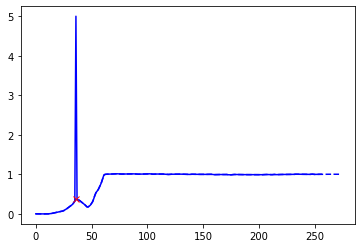

In [10]:
i = 17

plt.plot(t_clipped_max[i],'b')
peak_idx = detect_peaks(t_interp[i],mph=0.05)
p_structure = []
for peak in peak_idx:
    if 0.2 < t_interp[i,peak] < 0.963:
        p_structure.append(peak)
p_structure = np.array(p_structure)
print(p_structure)
plt.plot(t_interp[i],'b--')
plt.plot(p_structure,t_interp[i,p_structure],'rx')


In [11]:
indices = np.arange(len(np.array(df_labels['Label'])))
#X_train, X_test, y_train, y_test,id_train,id_test = train_test_split(t_interp, np.array(df_labels['Label']),indices, test_size=0.33,random_state = 10)
#X_train, X_test, y_train, y_test,id_train,id_test = train_test_split(t_clipped_max, np.array(df_labels['Label']),indices, test_size=0.33)
X_train, X_test, y_train, y_test,id_train,id_test = train_test_split(t_clipped, np.array(df_labels['Label']),indices, test_size=0.33)

In [12]:
df_labels[df_labels.Label == 2].index

Int64Index([  7,  11,  13,  17,  19,  21,  22,  23,  28,  40,  59,  78,  82,
             85,  93, 104, 105, 106, 107, 109, 111, 113, 115, 117, 122, 124,
            125, 126, 127, 128, 132, 133, 134, 138, 139, 142, 145, 146, 147,
            148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161,
            163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 181, 184, 186,
            191, 193, 195, 197, 201, 202, 204, 206, 214, 218, 219, 224, 228,
            230, 248, 250, 273, 281, 284, 307, 311, 317, 320, 322, 325, 330,
            333, 343, 344, 345, 350, 353, 355, 374],
           dtype='int64')

In [13]:
df_labels.iloc[25]

File     20180521_034316_1p0_UVIS_U.h5
Label                                0
Name: 25, dtype: object

clipped max =  6.37735545437012 clipped =  1.699012356357159 interp =  2.137915742634032


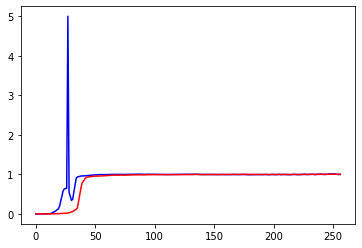

In [14]:
i,j = 7,8
print('clipped max = ',fastdtw(t_clipped_max[i],t_clipped_max[j],dist = euclidean)[0],'clipped = ',fastdtw(t_clipped[i],t_clipped[j],dist = euclidean)[0],'interp = ',fastdtw(t_interp[i],t_interp[j],dist = euclidean)[0])

plt.plot(t_clipped_max[i],'b')
plt.plot(t_clipped_max[j],'r')


In [15]:
dm = np.zeros((len(X_test),len(X_train)))

for i in tqdm(range(len(X_test))):
    
    t0 = np.zeros((len(X_test[0]),2))
    t0[:,0] = np.arange(len(X_test[0]))
    t0[:,1] = X_test[i]
    
    for j in range(len(X_train)):
        t1 = np.zeros((len(X_train[0]),2))
        t1[:,0] = np.arange(len(X_train[0]))
        t1[:,1] = X_train[j]
        
        #dm[i,j] =similaritymeasures.curve_length_measure(t0,t1)
        #dm[i,j] =similaritymeasures.pcm(t0,t1)
        #dm[i,j] =similaritymeasures.frechet_dist(t0,t1)
        #dm[i,j] = similaritymeasures.area_between_two_curves(t0,t1)
        dm[i,j] =similaritymeasures.dtw(t0,t1)[0]
        #dm[i,j] =fastdtw(t0,t1,dist = euclidean)[0]

ValueError: could not broadcast input array from shape (92) into shape (69)

In [ ]:
dm_sorted = dm[:,dm[:].argsort()]
sorted_id = dm[:].argsort()
label_matrix = y_train[sorted_id]


precision = []
for k in range(1,50):
    labels = []
    for i in range(len(y_test)):
        labels.append(sp.stats.mode(label_matrix[i,:k])[0][0])

    precision.append(precision_recall_fscore_support(labels,y_test,average = 'macro')[0])
    
k = np.array(np.where(precision == max(precision))).flatten() + 1

print('Max precision = ', max(precision), ' at k =', k)

In [ ]:
labels = []
for i in range(len(y_test)):
    labels.append(sp.stats.mode(label_matrix[i,:k[0]])[0][0])

labels = np.array(labels)
print(classification_report(labels,y_test))

In [ ]:
def show_false_files(pred_classes, show_files = False):

    false_files = np.array(df_labels.File.iloc[id_test[np.where(abs(pred_classes-y_test) != 0)]])
    df_false = pd.DataFrame(columns=['File','True Label','Predicted Label'],index=id_test[np.where(abs(pred_classes-y_test) != 0)])
    df_false['File'] = false_files
    a = []
    b = []
    for i in range(len(y_test)):
        if abs(pred_classes[i]-y_test[i]) != 0:
            a.append(y_test[i])
            b.append(pred_classes[i])

    df_false['True Label'] = a
    df_false['Predicted Label'] = b
    df_false.sort_index(inplace = True)

    if show_files:
        os.chdir(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Plot_%snm' %f_wav)
        file_list = os.listdir()
        for each_file in file_list:
            for _ in false_files:
                if each_file.startswith(_):
                    img = Image.open(each_file)
                    img.show()


    return df_false


show_false_files(pred_classes=labels)

In [ ]:
i = 26
plt.subplot(1,2,1)
plt.plot(t_clipped_max[i],'b')
peak_idx = detect_peaks(t_interp[i],mph=0.05)
p_structure = []
for peak in peak_idx:
    if 0.2 < t_interp[i,peak] < 0.963:
        p_structure.append(peak)
p_structure = np.array(p_structure)
print(p_structure)
plt.subplot(1,2,2)
plt.plot(t_interp[i],'b--')
plt.plot(p_structure,t_interp[i,p_structure],'rx')